<a href="https://colab.research.google.com/github/Unoaccaso/lab_projects/blob/master/gioco_del_saltabuco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulazioni numeriche per fenomeni d'interferenza

In [0]:
# ===================================
# Importazione delle librerie utili
# ===================================

# si sceglie numpy per la gestione di matrici e vettori
import numpy as np 
# libreria ottimizzata per l'esecuzione su GPU
try:
  import cupy as cp
except ModuleNotFoundError:
  !pip install cupy
  import cupy as cp
from time import time

import matplotlib.pyplot as plt
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

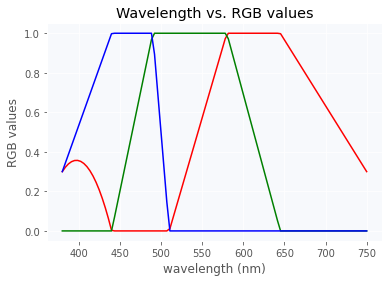

In [2]:
# ==================== 
# Physical Parameters  
# ====================
Ip = 4**2                 # peak intensity               
Ib = 1.0                  # background illumination                       
Lambda = 651e-9         # wavelength
k0 = 2*cp.pi/Lambda       # vacuum wavevector                 
n0 = 1.5                  # background index of refraction      
Lz = 1.                 # computational length of sample    
Lx = 4e-3                 # computational width of sample          

w0 = 0.25e-3              # beam width of gaussian beam parameter
h = 0.67e-3               # slit separation
inputposition=-0*1e-6     # input position 
inputposition=+h/2        # input position 

# =========================
# Computational Parameters 
# =========================
nstepx = 2000             # number of transverse grid points
nstepz = 7000             # number of longitudinal propagation steps

deltax = Lx/nstepx        # resolution in the x direction
deltaz = Lz/nstepz        # resolution in the z direction, IMPORTANT
deltaf = 1/Lx             # spatial frequency step

# ===================
# Meshgrid generation
# ===================
z = cp.arange(0, Lz+deltaz, deltaz)                
x = -Lx/2 + (cp.arange(0, nstepx, 1))*deltax

# =====================
# Dispersive Step Setup
# =====================
# this is to get rid of fftshifts and the sort

ntx = 0     
kx = cp.zeros(nstepx)                              
for nn in range(nstepx):
    ikx = nn - ntx
    kx[nn]=2*cp.pi*deltaf*ikx
    if nn + 1 - nstepx/2 == 0:
      ntx = nstepx
# =======================
# Input fields definition  
# =======================
def Gaussian(x, Ip = Ip, w0=w0, x0=0):
  return cp.sqrt(Ip)*cp.exp(-((x - x0)**2)/(w0**2))

# ================
# Propagation loop
# ================
def propagate(Field, dn=0, k = k0,  nstepz=nstepz, deltaz=deltaz,
              keep_memory=False, verbose=1, find_intensity_min = False):  
  start = time()
  # Fast fourier transform api
  fft, ifft = cp.fft.fft, cp.fft.ifft # faster with big matrices

  if keep_memory:
    FieldModuleMemory = cp.zeros(shape=(nstepx, nstepz+1))
    FieldModuleMemory[:, 0] = cp.abs(Field)
  elif find_intensity_min:
    R_intensity_ratio = []
  else:
    FieldModuleMemory = None
  ArgumentOfPropagator  = ((k*n0)**(-1)*(kx**2))*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  for hh in range(nstepz):
    # ================= DISPERSIVE HALF STEP =========================    
    FieldTransform=fft(Field, nstepx)
    FieldTransform=FieldTransform*Propagator
    Field=ifft(FieldTransform,nstepx)    
    # =================== ONE NONLINEAR STEP =========================
    Field=Field*cp.exp(-1j*k0*deltaz*dn)    
    # =================== DISPERSIVE HALF STEP =======================
    FieldTransform=fft(Field, nstepx)
    FieldTransform=FieldTransform*Propagator
    Field=ifft(FieldTransform,nstepx)

    if keep_memory:
      FieldModuleMemory[:, 1+hh] = cp.abs(Field)
    elif find_intensity_min:
      R_intensity_ratio.append(cp.sum(cp.abs(Field[x >= 0])**2, axis=0)/cp.sum(cp.abs(Field)**2, axis=0)-0.5)
      if hh > 0 and R_intensity_ratio[hh]*R_intensity_ratio[hh-1] <0:
        if verbose:
            print(f'elapsed time = {time()-start:.2f}')
        return hh*deltaz

  if verbose:
    print(f'elapsed time = {time()-start:.2f}')

  return Field, FieldModuleMemory

# =================
# Plotting function
# =================
def plot(Power, figsize=(15, 15), width=40, unit="mm"):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

# =============================
# To convert wavelength to cmap
#==============================
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

wavelengths = np.linspace(380, 750, 100) # in nanometers
rgbs = np.stack([cp.asnumpy(wavelength_to_rgb(wl)) for wl in wavelengths])
plt.plot(wavelengths, rgbs[:, 0], "r-")
plt.plot(wavelengths, rgbs[:, 1], "g-")
plt.plot(wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.show()

cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment

# ======================
# To plot final spectrum
# ======================
def propagate_and_get_rgb(InputField, wavelength, k=k0, dn=0):
  k = 2*np.pi/(wavelength)
  OutputField, FieldModuleMemory = propagate(InputField, dn=dn, k=k, keep_memory=True)
  P = cp.abs(OutputField)**2
  if P.ndim == 1:
    P = cp.stack((cp.abs(OutputField)**2,)*100, axis=0)
  rgb = cp.stack((P,)*3, axis=-1)/cp.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9), OutputField, FieldModuleMemory

# ====================
# Show result function
# ====================
def show_results(OutputPower, FieldModuleMemory, Color):
  fig = plt.figure(constrained_layout=True, figsize=(10, 10))
  gs = fig.add_gridspec(3, 3)

  ax1 = fig.add_subplot(gs[0, :2])
  ax1.set_title('Output power spectrum')
  ax1.plot(cp.asnumpy(x), cp.asnumpy(OutputPower))

  ax2 = fig.add_subplot(gs[1, :2])
  ax2.set_title('Diffracted light')
  ax2.imshow(cp.asnumpy(Color), extent=[x.min(), x.max(), 0, 1], aspect='auto')
  ax2.grid(False)

  ax3 = fig.add_subplot(gs[:2, 2])
  ax3.set_title('Diffracted light')
  ax3.imshow(cp.asnumpy(cp.abs(FieldModuleMemory.T)**2), origin='lower', 
             extent=[-0.02, 0.02, z.min(), z.max()], aspect = 'auto', 
             cmap='hot')
  ax3.grid(False)
  plt.show()
  plt.close()

[0. 0. 0. ... 0. 0. 0.]


(-7e-05, 7e-05)

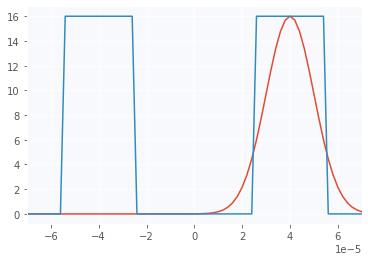

In [3]:
# =================
# Creating z=0 mask
# =================
InputField = 0*x           # Initializing field
dist = 50e-6               # distance betwen slices
width = 30e-6              # width of slices

# ================
# Making the guide
# ================
def n(x, n_value = 0.8*1e-4, dist = 2e-5, width = 30e-6):
  x = cp.asnumpy(x)
  dn = n_value*(np.heaviside(x-dist/2, n_value/2)-np.heaviside(x-dist/2-width, n_value/2) \
                  - np.heaviside(x+dist/2, n_value/2)+np.heaviside(x+dist/2+width, n_value/2))
  return cp.array(dn)
dn = n(x, dist=dist, width=width)
print(dn)
InputField += Gaussian(x, w0=20e-6, x0=dist/2+width/2)
InputPower = cp.abs(InputField)**2
# visualizing the field in z=0
plt.plot(cp.asnumpy(x), cp.asnumpy(InputPower))
plt.plot(cp.asnumpy(x), cp.asnumpy(Ip*dn/dn.max()))
plt.xlim((-7e-5, 7e-5))

elapsed time = 7.36


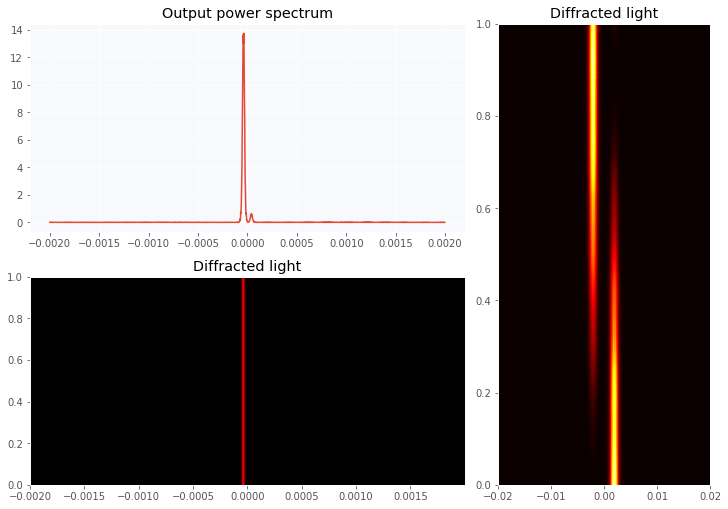

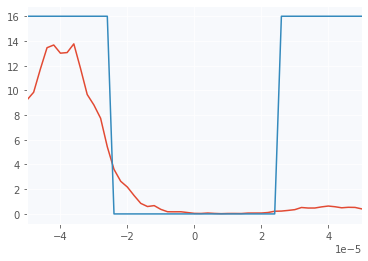

In [4]:
Color, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, Lambda, dn=dn)
show_results(cp.abs(OutputField)**2, FieldModuleMemory[np.abs(x)<4e-4, :], Color)
plt.plot(cp.asnumpy(x), cp.asnumpy(cp.abs(OutputField)**2))
plt.plot(cp.asnumpy(x), cp.asnumpy(Ip*dn/dn.max()))
plt.xlim((-5e-5, 5e-5))
plt.show()
plt.close()

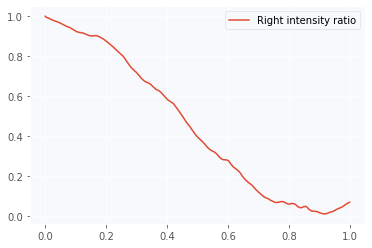

In [5]:
R_intensity_ratio = cp.sum(cp.abs(FieldModuleMemory[x >= 0, :])**2, axis=0)/cp.sum(cp.abs(FieldModuleMemory)**2, axis=0)
plt.plot(cp.asnumpy(z), cp.asnumpy(R_intensity_ratio), label='Right intensity ratio')
plt.legend()

In [6]:
propagate(InputField, dn=dn, find_intensity_min=True)

elapsed time = 4.71


0.45071428571428573

# Lughezza caratteristica del processo
Voglio trovare una lunghezza caratteristica, eseguo un fit sull'andamento cosinusoidale osservato per l'intensità.

In [7]:
from scipy.optimize import curve_fit as fit

def cos(x, omega):
  return np.cos(omega*x)**2

max_dist = 50
min_dist = 20
p0 =16
n_fits = 8
omegas = np.zeros(n_fits)
R_intensity_ratio  = cp.zeros((n_fits, len(z)))
dists = np.linspace(min_dist, max_dist, n_fits)
for i, dist in enumerate(dists):
  dn = n(x, dist=dist*1e-6, width=30e-6)
  InputField = x*0
  InputField += Gaussian(x, w0=20e-6, x0=dist*1e-6/2+30e-6/2)
  InputPower = cp.abs(InputField)**2
  OutputField, FieldModuleMemory = propagate(InputField, dn=dn, keep_memory=True)
  R_intensity_ratio[i] = cp.sum(cp.abs(FieldModuleMemory[x >= 0, :])**2, axis=0)/cp.sum(cp.abs(FieldModuleMemory)**2, axis=0)
  omegas[i], _ = fit(cos, cp.asnumpy(z), cp.asnumpy(R_intensity_ratio[i]), p0=[p0])

KeyboardInterrupt: ignored

In [0]:
fig, axs = plt.subplots(n_fits, 1, figsize=(15, 20))
for i, ax in enumerate(axs.reshape(-1)):
  ax.plot(cp.asnumpy(z), cos(cp.asnumpy(z), omegas[i]), color='r')
  ax.plot(cp.asnumpy(z), cp.asnumpy(R_intensity_ratio[i]), color='b')
  ax.title.set_text(f'dist = {dists[i]:.2f} mum - omega = {omegas[i]:.4f} m')

così definita la lunghezza caratteristica è il periodo spaziale dell'oscillazione. Questa definizione è utile per trovare z tale che l'intensità è a metà tra le due guide d'onda(L/4).